<a href="https://colab.research.google.com/github/xquynhtrinh/STA_141C_Final_Project/blob/main/Clustering_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering and PCA Goals

- Data Loading & Pre-processing Justification

- Choosing the optimal K
  - Plot the Elbow Curve, Silhouette Scores, and Davies-Bouldin Index

- PCA

- Answer prof's feedback " If I understand correctly, after pre-processing, there are 3 variables left? Why would PCA necessarily be a good idea in this case?"

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_theme(style="whitegrid", palette="muted")


In [4]:
rfm = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/STA 141C/rfm_clean.csv")

## Pre-processing: Log + Scale

In [13]:
# Isolate features that we want to cluster
features = ['Recency', 'Frequency', 'Monetary']
rfm_features = rfm[features].copy()

# Apply log-transf to handle skewness
rfm_log = np.log1p(rfm_features)

# Use StandardScalers to have all features' mean=0 & std=1
scaler = StandardScaler()
rfm_scaled_array = scaler.fit_transform(rfm_log)

# Use df for easier handling
rfm_scaled = pd.DataFrame(rfm_scaled_array, columns=features, index=rfm.index)

rfm_scaled.head()

,Recency,Frequency,Monetary
0,0.856701,1.254496,3.206219
1,-2.151979,0.800166,1.215993
2,-0.079138,0.299207,0.573185
3,-0.935308,0.073946,1.139846
4,0.824527,-1.058146,-0.723024


## Choosing the Optimal k

We evaluate three complementary metrics across k=2 to 8:

- **Inertia (Elbow Method):** Measures total within-cluster sum of squared distances. Lower is better, but always decreases as k increases. We look for the "elbow" — the point of diminishing returns.
- **Silhouette Score:** Measures how similar a point is to its own cluster vs. neighboring clusters. Ranges from −1 to +1; higher is better. This penalizes both loose clusters and over-splitting.
- **Davies-Bouldin Index:** Measures the ratio of within-cluster scatter to between-cluster separation. Lower is better. Unlike Silhouette, it directly penalizes clusters that are too close together.

The optimal k is the value where all three metrics agree, or where we can make the best business-interpretable trade-off.

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Range of k to test
k_range = range(2, 9)

inertias = []
silhouette_scores = []
db_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = km.fit_predict(rfm_scaled)

    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))
    db_scores.append(davies_bouldin_score(rfm_scaled, labels))

    print(f"k={k} | Inertia: {km.inertia_:.1f} | "
          f"Silhouette: {silhouette_score(rfm_scaled, labels):.4f} | "
          f"Davies-Bouldin: {davies_bouldin_score(rfm_scaled, labels):.4f}")


k=2 | Inertia: 8589.0 | Silhouette: 0.4386 | Davies-Bouldin: 0.8727
k=3 | Inertia: 6354.3 | Silhouette: 0.3477 | Davies-Bouldin: 1.0361
k=4 | Inertia: 4921.2 | Silhouette: 0.3650 | Davies-Bouldin: 0.9299
k=5 | Inertia: 4099.1 | Silhouette: 0.3425 | Davies-Bouldin: 0.9497
k=6 | Inertia: 3554.7 | Silhouette: 0.3348 | Davies-Bouldin: 0.9639
k=7 | Inertia: 3194.5 | Silhouette: 0.3066 | Davies-Bouldin: 0.9805
k=8 | Inertia: 2902.4 | Silhouette: 0.3033 | Davies-Bouldin: 0.9863


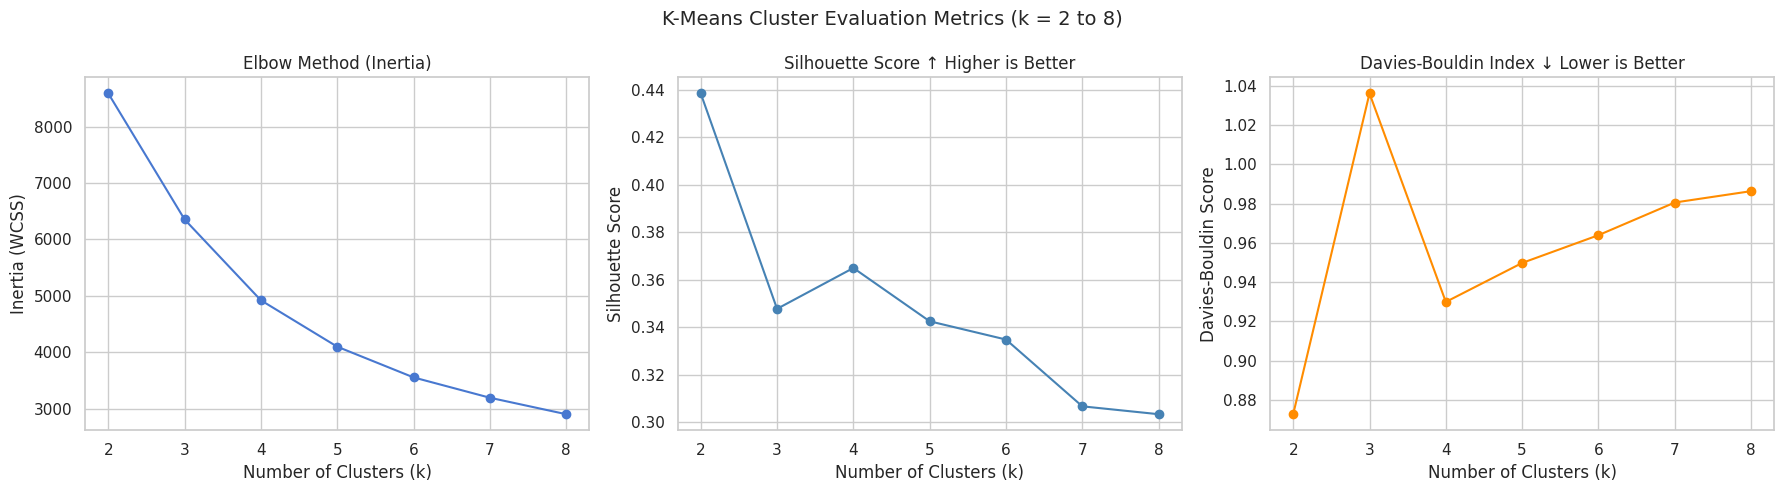

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("K-Means Cluster Evaluation Metrics (k = 2 to 8)", fontsize=14)

# Elbow
axes[0].plot(k_range, inertias, marker='o')
axes[0].set_title("Elbow Method (Inertia)")
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Inertia (WCSS)")

# Silhoutte Score
axes[1].plot(k_range, silhouette_scores, marker='o', color='steelblue')
axes[1].set_title("Silhouette Score ↑ Higher is Better")
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Silhouette Score")

# D-B Index
axes[2].plot(k_range, db_scores, marker='o', color='darkorange')
axes[2].set_title("Davies-Bouldin Index ↓ Lower is Better")
axes[2].set_xlabel("Number of Clusters (k)")
axes[2].set_ylabel("Davies-Bouldin Score")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/STA 141C/cluster_evaluation_metrics.png", dpi=150)
plt.show()

### Summary Table

In [18]:
results_df = pd.DataFrame({
    "k"                : list(k_range),
    "Inertia"          : [round(v, 1)  for v in inertias],
    "Silhouette Score" : [round(v, 4)  for v in silhouette_scores],
    "Davies-Bouldin"   : [round(v, 4)  for v in db_scores]
})

results_df

,k,Inertia,Silhouette Score,Davies-Bouldin
0,2,8589.0,0.4386,0.8727
1,3,6354.3,0.3477,1.0361
2,4,4921.2,0.3650,0.9299
3,5,4099.1,0.3425,0.9497
4,6,3554.7,0.3348,0.9639
5,7,3194.5,0.3066,0.9805
6,8,2902.4,0.3033,0.9863


### Interpretation and Choice of k

While purely geometric metrics often default to `k=2` in RFM distributions, business utility requires more granular segmentation. We look for the best local consensus across our metrics:

- **Elbow Method:** The reduction in within-cluster variance (WCSS) begins to clearly plateau after `k=4`.
- **Silhouette Score:** Disregarding the trivial `k=2` split, there is a distinct local maximum at `k=4` (Score ≈ 0.365), indicating that 4 clusters form a cohesive and well-separated partition compared to 3 or 5 clusters.
- **Davies-Bouldin Index:** The index hits a strong local minimum at `k=4` (Score ≈ 0.93) after a sharp penalty at `k=3`, confirming better cluster separation.

**Conclusion:** We select `k=4` as the optimal number of clusters. It is mathematically supported by local peaks/valleys in our metrics and provides the necessary granularity for actionable business segmentation (e.g., separating new customers from loyalists and at-risk churners).


#### Extra Notes for why do we use these metrics

In unsupervised customer segmentation, there is no "ground truth" to definitively prove a cluster assignment is correct. Relying on a single metric is a "blind application" that can easily mislead us, especially with right-skewed behavioral data like RFM.

1. Elbow Method (Inertia): Measures Compactness

- It calculates the sum of squared distances from each customer to their cluster's center

- Why use it here: in marketing, a segment is only useful if the people inside it behave very similarly. Inertia ensures our segments are tightly packed (compact). However, inertia always decreases as $k$ increases, meaning if we only used this metric, we might overfit and create dozens of tiny, useless micro-segments

2. Silhouette Score: Measures separation vs Cohesion

- It measures how close a customer is to their 'own' cluster compared to the 'nearest neighboring' cluster

- Why use it: We need our marketing segments to be distinct. A "Loyalist" must have a measurably different behavioral profile than an "At-Risk" customer. The Silhouette score penalizes the model if clusters overlap or blur together.

3. Davies-Bouldin Index: Measures Density & Overlap

- It calculates the ratio of within-cluster scatter to between-cluster separation

- Why use it: RFM data typically contains a massive, dense "blob" of average customers and a sparse scattering of "whales" (high spenders). The DB index explicitly penalizes clusters that are too close together relative to their size. It is particularly robust at helping us figure out where to draw boundaries through that massive middle-tier of customers without creating artificial overlap.

Using these three methods ensure our clusters are tight, distinct from one another, and well-separated despite varying densities.

### Fit the model with chosen k = 4

In [22]:
# 1. Fit k-means w/ k=4
OPTIMAL_K = 4
km_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=42)
rfm['Cluster'] = km_final.fit_predict(rfm_scaled)

# 2. Inverse the log and scaling to see the REAL values for each cluster
# use median instead of mean bc RFM distributions are right-skewed
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'median',
    'Frequency': 'median',
    'Monetary': ['median', 'count']
}).round(1)

cluster_profile.columns = ['Median Recency', 'Median Frequency', 'Median Monetary', 'Customer Count']
cluster_profile = cluster_profile.sort_values('Median Monetary', ascending=False)

cluster_profile


,Median Recency,Median Frequency,Median Monetary,Customer Count
Cluster,,,,
2,17.0,13.0,4986.1,1196
3,186.0,4.0,1450.0,1459
1,24.0,3.0,734.1,1250
0,402.0,1.0,273.3,1973


### The Business Profile

**1. Cluster 2: "Champions" & "Loyalists"**

- Bought very recently (17 days), buy often (13 times), and spend by far the most (£4,986).

- This is highly-profitable segment. They generate the huge majority of revenue despite being only ~20% of the customer base

**2. Cluster 3: "At Risk"**

- Moderate spend (£1,450) and frequency (4 times), but haven't bought in over half a year (186 days).

- These customers used to be good, but they are drifting away. They are prime targets for win-back campaigns.

**3. Cluster 1: "Potential Loyalists"**

- Bought recently (24 days), but low frequency (3 times) and low spend (£734).

- These are newer or casual customers. They are currently active, so the goal is to up-sell them and increase their frequency before they churn.

**4. Cluster 0: "Lost"**

- Haven't bought in over a year (402 days), bought only once, and spent the least (£273).

- This is largest group (1,973 customers). They were likely one-off holiday shoppers or people who churned long ago. Spending heavy marketing budget here is likely a waste.

## PCA

In EDA, we proved that F and M are highly correlated (r = .85). Feeding highly correlated features into logistic regression inflates coeff. variance and destabilitizes the model.
Thus, we will use PCA to reduce the 3 correlated RFM variables into orthogonal components for the logistic regression model.

In [27]:
from sklearn.decomposition import PCA

# Fit pca on the transf. data
pca = PCA(n_components=None, random_state=42)
pca.fit(rfm_scaled)

# Calc R^2
R_sqrt = pca.explained_variance_ratio_ * 100
cum_var = np.cumsum(R_sqrt)

# df to show results
pca_summary = pd.DataFrame({
    'Principal Component': ['PC1', 'PC2', 'PC3'],
    'Explained Variance' : R_sqrt,
    'Cumulative Variance' : cum_var
})

pca_summary

,Principal Component,Explained Variance,Cumulative Variance
0,PC1,76.356725,76.356725
1,PC2,18.744412,95.101136
2,PC3,4.898864,100.000000


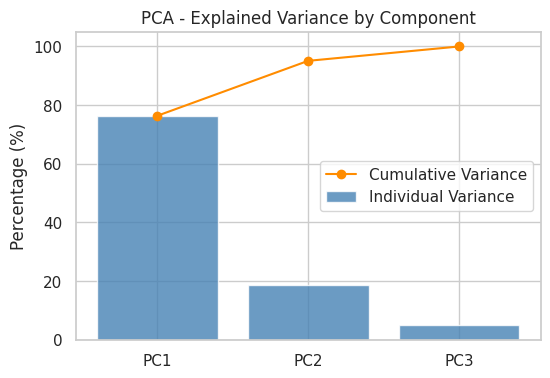

In [30]:
# Plot R^2
plt.figure(figsize=(6, 4))
plt.bar(['PC1', 'PC2', 'PC3'], R_sqrt, color='steelblue', alpha=0.8, label='Individual Variance')
plt.plot(['PC1', 'PC2', 'PC3'], cum_var, marker='o', color='darkorange', label='Cumulative Variance')
plt.title("PCA - Explained Variance by Component")
plt.ylabel("Percentage (%)")
plt.legend()
plt.show()

### Interpreting the Plot Results

- PC1 captures ~76% of all the variance
- PC2 captures ~19%

-> PC1 + PC2 capture ~95% of the total info

So we only lose ~5% of info if reducing 3 dimensions down to 2. This will make logistic regression model simpler and less prone to overfitting.

In [31]:
# actual component loadings
# how much RFM contribute to each PC
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=features)
loadings.round(3)

,PC1,PC2,PC3
Recency,-0.505,0.860,0.077
Frequency,0.617,0.297,0.729
Monetary,0.604,0.415,-0.680


### Meaning of the PCs based on the loadings table

PC1:
- Because F and M are highly positive, R is negative. Thus, PC1 represents "Overall Customer Value". So high PC1 score means a customer buys often, spends a lot, and bought recently.

PC2:
- Recency is massively positive here, so this component is heavily dirven by how long it's been since a customer last bought. PC2 represents "Inactivity".